In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# getting the housing data and splitting into training and test set with 80/20 split

data = pd.read_csv('Housing.csv')
train_data, test_data = train_test_split(data, test_size=0.2)

In [3]:
# visualize the data
print(train_data)

        price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
310   4130000  5985         3          1        1      yes        no      yes   
401   3500000  9500         3          1        2      yes        no       no   
59    7210000  6000         3          2        4      yes       yes       no   
126   5880000  7160         3          1        1      yes        no      yes   
166   5320000  7800         3          1        1      yes        no      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
416   3395000  3450         3          1        1      yes        no      yes   
491   2835000  2640         2          1        1       no        no       no   
477   2940000  4960         2          1        1      yes        no       no   
309   4130000  4632         4          1        2      yes        no       no   
6    10150000  8580         4          3        4      yes        no       no   

    hotwaterheating aircond

In [4]:
# how to plot data as a scatterplot with matplotlib for one variable
plt.scatter(x_train[0], y_train, marker = "x", c = "b")
#setting the title
plt.title("Housing prices")
plt.ylabel("price in millions")
plt.xlabel("size of house in sqft")
plt.show()

NameError: name 'x_train' is not defined

In [5]:
# Data Preprocessing

# turn the data into numpy arrays
train_data = pd.DataFrame(train_data).to_numpy()
test_data = pd.DataFrame(test_data).to_numpy()

# extracting relevant features for x_train such as area, # bedrooms, bathrooms, stories, basement(Y/N), # parking spaces
x_train = np.column_stack((train_data[:,1], train_data[:,2], train_data[:,3], train_data[:,4], train_data[:,7], train_data[:,10]))
y_train = train_data[:, 0]
x_test = np.column_stack((test_data[:,1], test_data[:,2], test_data[:,3], test_data[:,4], test_data[:,7], test_data[:,10]))
y_test = test_data[:, 0]

#Using one hot encoding to change categorical data into numerical data
for i in range (x_train.shape[0]):
    for j in range(x_train.shape[1]):
        if x_train[i][j] == 'yes':
            x_train[i][j] = 1
        elif x_train[i][j] == 'no':
            x_train[i][j] = 0
            
for i in range (x_test.shape[0]):
    for j in range(x_test.shape[1]):
        if x_test[i][j] == 'yes':
            x_test[i][j] = 1
        elif x_test[i][j] == 'no':
            x_test[i][j] = 0


# Taking the transpose. x is a data matrix where each column is an individual example
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

y_train = np.reshape(y_train, (1, y_train.shape[0]))
y_test = np.reshape(y_test, (1, y_test.shape[0]))

# converting all the data values to float types so numpy methods work 
x_train = x_train.astype(float)
y_train = y_train.astype(float)
x_test = x_test.astype(float)
y_test = y_test.astype(float)

# Normalizing the data for more efficient convergence (vectorized). 
# - Mean normalization for input data
# - dividing by 1,000,000 for output data (price)

x_train = (x_train - np.mean(x_train, axis = 1, keepdims = True)) / np.std(x_train, axis = 1, keepdims = True)
x_test = (x_test - np.mean(x_test, axis = 1, keepdims = True)) / np.std(x_test, axis = 1, keepdims = True)

#y_train = y_train / 10.0 ** 6
#y_test = y_test / 10.0 ** 6

Training a Neural Network to Predict Housing Prices

In [6]:
def sigmoid(Z):
    """
    Vectorized implementation of the sigmoid activation function applied to a matrix
    """
    Z = np.clip(Z, -500, 500) # to prevent overflow
    A = 1 / (1 + np.exp(-Z))
    return A

def relu(Z):
    """
    Vectorized implementation of the relu activation function applied to a matrix
    """
    A = Z * (Z > 0)
    return A

In [7]:
def deriv_sigmoid(Z):
    return Z * (1 - Z)
def deriv_relu(Z):
    return np.where(Z > 0, 1, 0)

In [8]:
class NN:
    def __init__(self, structure) -> None:
        """
        Initialization method of the neural network:
        
        - the structure contains the dimension of the input layer followed by L-1 hidden layers 
        and an output layer
        - bias is a dictionary containing the bias vectors for each hidden/output layer
        - weight is a dictionary containing the weight matrices for each hidden/output layer
        """
        self.structure = structure
        self.bias = {"b" + str(layer_i) : np.zeros((structure[layer_i][0], 1)) for layer_i in range(1, len(structure))}
        
        self.weight = {"W" + str(layer_i) : np.random.randn(structure[layer_i][0], structure[layer_i - 1][0]) for layer_i in range(1, len(structure))}
    
    def cost(self, X, Y):
        """
        Calculates Mean squared Error
        """
        A = self.forwardProp(X)
        return np.sum((A - Y) ** 2) / (2 * X.shape[1])
        
    
    def forwardProp(self, X):
        """
        Vectorized implementation of the forward propagation algorithm.
        it applies the activation function specified in the structure of the initialization method
            - supports ReLU, sigmoid, and identity activation
        
        Returns AL, the activations of the output layer
        """
        A = np.copy(X)
        for layer_i in range (1, len(self.structure)):
            W_i = self.weight["W" + str(layer_i)]
            b_i = self.bias["b" + str(layer_i)]
            
            assert np.shape(W_i)[1] == np.shape(A)[0]  # ensures dimensions align for matrix multiplication
            
            Z_i = np.dot(W_i, A) + b_i

            if self.structure[layer_i][1] == 'sigmoid':
                A = sigmoid(Z_i)
            elif self.structure[layer_i][1] == 'linear':
                A = Z_i
            elif self.structure[layer_i][1] == 'relu':
                A = relu(Z_i)
        return A
    
    def backProp(self, X, Y):
        """
        Vectorized implementation of the backpropagation algorithm.
        
        returns a dictionary of the gradients wrt W and B
        """
        gradsW = {"dW" + str(layer_i) : np.zeros((self.structure[layer_i][0], self.structure[layer_i - 1][0])) for layer_i in range(1, len(self.structure))}
        gradsB = {"db" + str(layer_i) : np.zeros((self.structure[layer_i][0], 1)) for layer_i in range(1, len(self.structure))}
        Z_cache = {}
        A_cache = {}
        
        # forward propagation to fill Z_cache
        A = np.copy(X)
        A_cache["A0"] = X
        for layer_i in range (1, len(self.structure)):
            W_i = self.weight["W" + str(layer_i)]
            b_i = self.bias["b" + str(layer_i)]
            
            assert np.shape(W_i)[1] == np.shape(A)[0]  # ensures dimensions align for matrix multiplication
            
            Z_i = np.dot(W_i, A) + b_i
            Z_cache["Z" + str(layer_i)] = Z_i
            
            if self.structure[layer_i][1] == 'sigmoid':
                A = sigmoid(Z_i)
            elif self.structure[layer_i][1] == 'linear':
                A = Z_i
            elif self.structure[layer_i][1] == 'relu':
                A = relu(Z_i)
            
            A_cache["A" + str(layer_i)] = A
        
        m = X.shape[1] # no. of training examples
        dA = (1 / m) * (A - Y) #since the last layer is linear for our purposes
        
        for layer_i in range (len(self.structure) - 1, 0, -1):
            
            # we want cost wrt Z but dA/dZ depends on the activation function used so we account for this
            if self.structure[layer_i][1] == 'sigmoid':
                dZi = np.multiply(dA, deriv_sigmoid(Z_cache["Z" + str(layer_i)]))
                
            elif self.structure[layer_i][1] == 'linear':
                dZi = dA * 1
                
            elif self.structure[layer_i][1] == 'relu':
                dZi = np.multiply(dA, deriv_relu(Z_cache["Z" + str(layer_i)]))
            #print(dZi)
            
            gradsW["dW" + str(layer_i)] = (1/m) * np.dot(dZi, A_cache["A" + str(layer_i - 1)].T)
            gradsB["db" + str(layer_i)] = (1/m) * np.sum(dZi, axis = 1, keepdims = True)
            dA = np.dot(gradsW["dW" + str(layer_i)].T, dZi)
        
        return gradsW, gradsB
    
    def gradient_descent(self, iterations, learning_rate, X, Y):
        """gradient descent
        returns costs np array where the ith value is the model's cost at the ith iteration"""
        gradsW, gradsB = self.backProp(X, Y)
        learning_curve = np.zeros(iterations)
        
        for itr in range(iterations):
            for layer_i in range(1, len(self.structure)):
                assert self.weight["W" + str(layer_i)].shape == gradsW["dW" + str(layer_i)].shape
                assert self.bias["b" + str(layer_i)].shape == gradsB["db" + str(layer_i)].shape
                
                self.weight["W" + str(layer_i)] = self.weight["W" + str(layer_i)] - learning_rate * gradsW["dW" + str(layer_i)]
                # self.bias["b" + str(layer_i)] = self.bias["b" + str(layer_i)] - learning_rate * gradsB["db" + str(layer_i)]
            learning_curve[itr] = self.cost(X, Y)
        
        return learning_curve
            

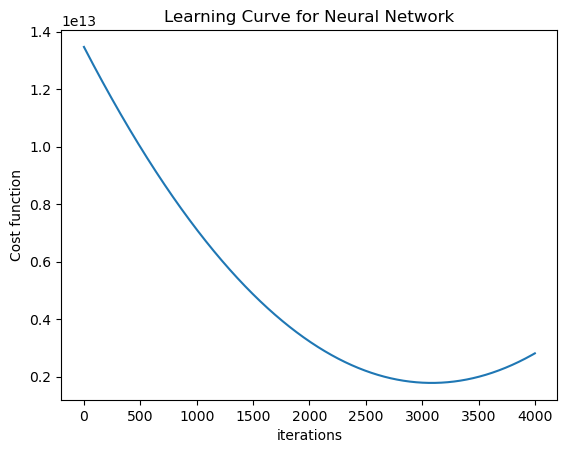

training set MSE:  2808593223267.228
test set MSE:  3154300588637.1387
2228109.8018429214


In [11]:
predictor = NN([(6, 'input'), (4, 'sigmoid'), (4, 'sigmoid'),(4, 'sigmoid'),(1, 'linear')])
iters = 4000
costs = predictor.gradient_descent(iters, 0.092, x_train, y_train)

plt.plot(np.arange(iters), costs);
plt.title("Learning Curve for Neural Network")
plt.ylabel("Cost function")
plt.xlabel("iterations")
plt.show()

print("training set MSE: ", predictor.cost(x_train, y_train))
print("test set MSE: ", predictor.cost(x_test, y_test))

print(np.sum(np.abs(predictor.forwardProp(x_test) - y_test)) / x_test.shape[1])


Neural Network coded from scratch has a similar mean absolute error to the tensorflow implementation

Trying Tensorflow Neural Network of same type

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError

tf.random.set_seed(42)

model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(6,)))
model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1,))
model.output_shape


model.compile(loss = MeanSquaredError())
model.fit(x_train.T, y_train.T, epochs = 4000)

prediction = model.predict(x_test.T)

tf_mae_loss = keras.metrics.mean_absolute_error(y_test.T, prediction)
MAE = tf.reduce_mean(tf_mae_loss, axis=0)
print(MAE)

Epoch 1/4000
14/14 [==============================] - 0s 472us/step - loss: 26949946703872.0000
Epoch 2/4000
14/14 [==============================] - 0s 307us/step - loss: 26949944606720.0000
Epoch 3/4000
14/14 [==============================] - 0s 288us/step - loss: 26949946703872.0000
Epoch 4/4000
14/14 [==============================] - 0s 328us/step - loss: 26949944606720.0000
Epoch 5/4000
14/14 [==============================] - 0s 328us/step - loss: 26949942509568.0000
Epoch 6/4000
14/14 [==============================] - 0s 349us/step - loss: 26949944606720.0000
Epoch 7/4000
14/14 [==============================] - 0s 335us/step - loss: 26949940412416.0000
Epoch 8/4000
14/14 [==============================] - 0s 325us/step - loss: 26949940412416.0000
Epoch 9/4000
14/14 [==============================] - 0s 328us/step - loss: 26949942509568.0000
Epoch 10/4000
14/14 [==============================] - 0s 314us/step - loss: 26949942509568.0000
Epoch 11/4000
14/14 [==================

14/14 [==============================] - 0s 314us/step - loss: 26949900566528.0000
Epoch 86/4000
14/14 [==============================] - 0s 308us/step - loss: 26949902663680.0000
Epoch 87/4000
14/14 [==============================] - 0s 336us/step - loss: 26949902663680.0000
Epoch 88/4000
14/14 [==============================] - 0s 311us/step - loss: 26949902663680.0000
Epoch 89/4000
14/14 [==============================] - 0s 296us/step - loss: 26949900566528.0000
Epoch 90/4000
14/14 [==============================] - 0s 331us/step - loss: 26949900566528.0000
Epoch 91/4000
14/14 [==============================] - 0s 289us/step - loss: 26949898469376.0000
Epoch 92/4000
14/14 [==============================] - 0s 311us/step - loss: 26949898469376.0000
Epoch 93/4000
14/14 [==============================] - 0s 328us/step - loss: 26949898469376.0000
Epoch 94/4000
14/14 [==============================] - 0s 297us/step - loss: 26949894275072.0000
Epoch 95/4000
14/14 [=======================

14/14 [==============================] - 0s 305us/step - loss: 26949854429184.0000
Epoch 169/4000
14/14 [==============================] - 0s 315us/step - loss: 26949850234880.0000
Epoch 170/4000
14/14 [==============================] - 0s 311us/step - loss: 26949850234880.0000
Epoch 171/4000
14/14 [==============================] - 0s 296us/step - loss: 26949856526336.0000
Epoch 172/4000
14/14 [==============================] - 0s 298us/step - loss: 26949854429184.0000
Epoch 173/4000
14/14 [==============================] - 0s 311us/step - loss: 26949856526336.0000
Epoch 174/4000
14/14 [==============================] - 0s 312us/step - loss: 26949848137728.0000
Epoch 175/4000
14/14 [==============================] - 0s 301us/step - loss: 26949850234880.0000
Epoch 176/4000
14/14 [==============================] - 0s 310us/step - loss: 26949848137728.0000
Epoch 177/4000
14/14 [==============================] - 0s 308us/step - loss: 26949848137728.0000
Epoch 178/4000
14/14 [=============

14/14 [==============================] - 0s 305us/step - loss: 26949812486144.0000
Epoch 252/4000
14/14 [==============================] - 0s 309us/step - loss: 26949808291840.0000
Epoch 253/4000
14/14 [==============================] - 0s 305us/step - loss: 26949808291840.0000
Epoch 254/4000
14/14 [==============================] - 0s 314us/step - loss: 26949808291840.0000
Epoch 255/4000
14/14 [==============================] - 0s 326us/step - loss: 26949806194688.0000
Epoch 256/4000
14/14 [==============================] - 0s 313us/step - loss: 26949804097536.0000
Epoch 257/4000
14/14 [==============================] - 0s 310us/step - loss: 26949808291840.0000
Epoch 258/4000
14/14 [==============================] - 0s 326us/step - loss: 26949806194688.0000
Epoch 259/4000
14/14 [==============================] - 0s 315us/step - loss: 26949804097536.0000
Epoch 260/4000
14/14 [==============================] - 0s 313us/step - loss: 26949806194688.0000
Epoch 261/4000
14/14 [=============

14/14 [==============================] - 0s 314us/step - loss: 26949764251648.0000
Epoch 335/4000
14/14 [==============================] - 0s 308us/step - loss: 26949762154496.0000
Epoch 336/4000
14/14 [==============================] - 0s 307us/step - loss: 26949764251648.0000
Epoch 337/4000
14/14 [==============================] - 0s 334us/step - loss: 26949762154496.0000
Epoch 338/4000
14/14 [==============================] - 0s 321us/step - loss: 26949760057344.0000
Epoch 339/4000
14/14 [==============================] - 0s 305us/step - loss: 26949762154496.0000
Epoch 340/4000
14/14 [==============================] - 0s 322us/step - loss: 26949762154496.0000
Epoch 341/4000
14/14 [==============================] - 0s 305us/step - loss: 26949762154496.0000
Epoch 342/4000
14/14 [==============================] - 0s 304us/step - loss: 26949760057344.0000
Epoch 343/4000
14/14 [==============================] - 0s 337us/step - loss: 26949762154496.0000
Epoch 344/4000
14/14 [=============

14/14 [==============================] - 0s 326us/step - loss: 26949718114304.0000
Epoch 418/4000
14/14 [==============================] - 0s 323us/step - loss: 26949720211456.0000
Epoch 419/4000
14/14 [==============================] - 0s 301us/step - loss: 26949718114304.0000
Epoch 420/4000
14/14 [==============================] - 0s 334us/step - loss: 26949716017152.0000
Epoch 421/4000
14/14 [==============================] - 0s 308us/step - loss: 26949720211456.0000
Epoch 422/4000
14/14 [==============================] - 0s 306us/step - loss: 26949720211456.0000
Epoch 423/4000
14/14 [==============================] - 0s 332us/step - loss: 26949718114304.0000
Epoch 424/4000
14/14 [==============================] - 0s 307us/step - loss: 26949718114304.0000
Epoch 425/4000
14/14 [==============================] - 0s 295us/step - loss: 26949713920000.0000
Epoch 426/4000
14/14 [==============================] - 0s 302us/step - loss: 26949713920000.0000
Epoch 427/4000
14/14 [=============

14/14 [==============================] - 0s 308us/step - loss: 26949674074112.0000
Epoch 501/4000
14/14 [==============================] - 0s 688us/step - loss: 26949674074112.0000
Epoch 502/4000
14/14 [==============================] - 0s 472us/step - loss: 26949674074112.0000
Epoch 503/4000
14/14 [==============================] - 0s 333us/step - loss: 26949674074112.0000
Epoch 504/4000
14/14 [==============================] - 0s 312us/step - loss: 26949674074112.0000
Epoch 505/4000
14/14 [==============================] - 0s 302us/step - loss: 26949674074112.0000
Epoch 506/4000
14/14 [==============================] - 0s 327us/step - loss: 26949671976960.0000
Epoch 507/4000
14/14 [==============================] - 0s 310us/step - loss: 26949671976960.0000
Epoch 508/4000
14/14 [==============================] - 0s 302us/step - loss: 26949671976960.0000
Epoch 509/4000
14/14 [==============================] - 0s 321us/step - loss: 26949667782656.0000
Epoch 510/4000
14/14 [=============

14/14 [==============================] - 0s 324us/step - loss: 26949632131072.0000
Epoch 584/4000
14/14 [==============================] - 0s 301us/step - loss: 26949632131072.0000
Epoch 585/4000
14/14 [==============================] - 0s 345us/step - loss: 26949630033920.0000
Epoch 586/4000
14/14 [==============================] - 0s 318us/step - loss: 26949630033920.0000
Epoch 587/4000
14/14 [==============================] - 0s 308us/step - loss: 26949630033920.0000
Epoch 588/4000
14/14 [==============================] - 0s 329us/step - loss: 26949625839616.0000
Epoch 589/4000
14/14 [==============================] - 0s 304us/step - loss: 26949623742464.0000
Epoch 590/4000
14/14 [==============================] - 0s 309us/step - loss: 26949625839616.0000
Epoch 591/4000
14/14 [==============================] - 0s 305us/step - loss: 26949623742464.0000
Epoch 592/4000
14/14 [==============================] - 0s 312us/step - loss: 26949623742464.0000
Epoch 593/4000
14/14 [=============

14/14 [==============================] - 0s 322us/step - loss: 26949585993728.0000
Epoch 667/4000
14/14 [==============================] - 0s 321us/step - loss: 26949585993728.0000
Epoch 668/4000
14/14 [==============================] - 0s 307us/step - loss: 26949581799424.0000
Epoch 669/4000
14/14 [==============================] - 0s 321us/step - loss: 26949588090880.0000
Epoch 670/4000
14/14 [==============================] - 0s 301us/step - loss: 26949581799424.0000
Epoch 671/4000
14/14 [==============================] - 0s 309us/step - loss: 26949581799424.0000
Epoch 672/4000
14/14 [==============================] - 0s 342us/step - loss: 26949579702272.0000
Epoch 673/4000
14/14 [==============================] - 0s 310us/step - loss: 26949581799424.0000
Epoch 674/4000
14/14 [==============================] - 0s 301us/step - loss: 26949585993728.0000
Epoch 675/4000
14/14 [==============================] - 0s 328us/step - loss: 26949577605120.0000
Epoch 676/4000
14/14 [=============

14/14 [==============================] - 0s 295us/step - loss: 26949537759232.0000
Epoch 750/4000
14/14 [==============================] - 0s 301us/step - loss: 26949537759232.0000
Epoch 751/4000
14/14 [==============================] - 0s 334us/step - loss: 26949537759232.0000
Epoch 752/4000
14/14 [==============================] - 0s 299us/step - loss: 26949537759232.0000
Epoch 753/4000
14/14 [==============================] - 0s 297us/step - loss: 26949537759232.0000
Epoch 754/4000
14/14 [==============================] - 0s 313us/step - loss: 26949539856384.0000
Epoch 755/4000
14/14 [==============================] - 0s 299us/step - loss: 26949537759232.0000
Epoch 756/4000
14/14 [==============================] - 0s 313us/step - loss: 26949539856384.0000
Epoch 757/4000
14/14 [==============================] - 0s 310us/step - loss: 26949535662080.0000
Epoch 758/4000
14/14 [==============================] - 0s 316us/step - loss: 26949533564928.0000
Epoch 759/4000
14/14 [=============

14/14 [==============================] - 0s 305us/step - loss: 26949497913344.0000
Epoch 833/4000
14/14 [==============================] - 0s 302us/step - loss: 26949495816192.0000
Epoch 834/4000
14/14 [==============================] - 0s 319us/step - loss: 26949495816192.0000
Epoch 835/4000
14/14 [==============================] - 0s 306us/step - loss: 26949493719040.0000
Epoch 836/4000
14/14 [==============================] - 0s 294us/step - loss: 26949491621888.0000
Epoch 837/4000
14/14 [==============================] - 0s 301us/step - loss: 26949493719040.0000
Epoch 838/4000
14/14 [==============================] - 0s 329us/step - loss: 26949489524736.0000
Epoch 839/4000
14/14 [==============================] - 0s 307us/step - loss: 26949489524736.0000
Epoch 840/4000
14/14 [==============================] - 0s 311us/step - loss: 26949491621888.0000
Epoch 841/4000
14/14 [==============================] - 0s 316us/step - loss: 26949489524736.0000
Epoch 842/4000
14/14 [=============

14/14 [==============================] - 0s 333us/step - loss: 26949453873152.0000
Epoch 916/4000
14/14 [==============================] - 0s 302us/step - loss: 26949451776000.0000
Epoch 917/4000
14/14 [==============================] - 0s 300us/step - loss: 26949449678848.0000
Epoch 918/4000
14/14 [==============================] - 0s 325us/step - loss: 26949447581696.0000
Epoch 919/4000
14/14 [==============================] - 0s 299us/step - loss: 26949449678848.0000
Epoch 920/4000
14/14 [==============================] - 0s 293us/step - loss: 26949449678848.0000
Epoch 921/4000
14/14 [==============================] - 0s 303us/step - loss: 26949447581696.0000
Epoch 922/4000
14/14 [==============================] - 0s 327us/step - loss: 26949447581696.0000
Epoch 923/4000
14/14 [==============================] - 0s 306us/step - loss: 26949445484544.0000
Epoch 924/4000
14/14 [==============================] - 0s 307us/step - loss: 26949447581696.0000
Epoch 925/4000
14/14 [=============

14/14 [==============================] - 0s 314us/step - loss: 26949405638656.0000
Epoch 999/4000
14/14 [==============================] - 0s 321us/step - loss: 26949403541504.0000
Epoch 1000/4000
14/14 [==============================] - 0s 293us/step - loss: 26949405638656.0000
Epoch 1001/4000
14/14 [==============================] - 0s 315us/step - loss: 26949399347200.0000
Epoch 1002/4000
14/14 [==============================] - 0s 322us/step - loss: 26949405638656.0000
Epoch 1003/4000
14/14 [==============================] - 0s 299us/step - loss: 26949405638656.0000
Epoch 1004/4000
14/14 [==============================] - 0s 295us/step - loss: 26949399347200.0000
Epoch 1005/4000
14/14 [==============================] - 0s 327us/step - loss: 26949405638656.0000
Epoch 1006/4000
14/14 [==============================] - 0s 311us/step - loss: 26949403541504.0000
Epoch 1007/4000
14/14 [==============================] - 0s 308us/step - loss: 26949399347200.0000
Epoch 1008/4000
14/14 [====

14/14 [==============================] - 0s 300us/step - loss: 26949361598464.0000
Epoch 1081/4000
14/14 [==============================] - 0s 303us/step - loss: 26949361598464.0000
Epoch 1082/4000
14/14 [==============================] - 0s 336us/step - loss: 26949357404160.0000
Epoch 1083/4000
14/14 [==============================] - 0s 298us/step - loss: 26949357404160.0000
Epoch 1084/4000
14/14 [==============================] - 0s 305us/step - loss: 26949357404160.0000
Epoch 1085/4000
14/14 [==============================] - 0s 318us/step - loss: 26949361598464.0000
Epoch 1086/4000
14/14 [==============================] - 0s 307us/step - loss: 26949357404160.0000
Epoch 1087/4000
14/14 [==============================] - 0s 296us/step - loss: 26949355307008.0000
Epoch 1088/4000
14/14 [==============================] - 0s 327us/step - loss: 26949357404160.0000
Epoch 1089/4000
14/14 [==============================] - 0s 310us/step - loss: 26949355307008.0000
Epoch 1090/4000
14/14 [===

14/14 [==============================] - 0s 327us/step - loss: 26949317558272.0000
Epoch 1163/4000
14/14 [==============================] - 0s 314us/step - loss: 26949317558272.0000
Epoch 1164/4000
14/14 [==============================] - 0s 307us/step - loss: 26949319655424.0000
Epoch 1165/4000
14/14 [==============================] - 0s 332us/step - loss: 26949313363968.0000
Epoch 1166/4000
14/14 [==============================] - 0s 315us/step - loss: 26949317558272.0000
Epoch 1167/4000
14/14 [==============================] - 0s 313us/step - loss: 26949313363968.0000
Epoch 1168/4000
14/14 [==============================] - 0s 303us/step - loss: 26949313363968.0000
Epoch 1169/4000
14/14 [==============================] - 0s 310us/step - loss: 26949311266816.0000
Epoch 1170/4000
14/14 [==============================] - 0s 308us/step - loss: 26949313363968.0000
Epoch 1171/4000
14/14 [==============================] - 0s 301us/step - loss: 26949311266816.0000
Epoch 1172/4000
14/14 [===

14/14 [==============================] - 0s 305us/step - loss: 26949271420928.0000
Epoch 1245/4000
14/14 [==============================] - 0s 332us/step - loss: 26949271420928.0000
Epoch 1246/4000
14/14 [==============================] - 0s 313us/step - loss: 26949271420928.0000
Epoch 1247/4000
14/14 [==============================] - 0s 291us/step - loss: 26949271420928.0000
Epoch 1248/4000
14/14 [==============================] - 0s 332us/step - loss: 26949271420928.0000
Epoch 1249/4000
14/14 [==============================] - 0s 328us/step - loss: 26949269323776.0000
Epoch 1250/4000
14/14 [==============================] - 0s 315us/step - loss: 26949267226624.0000
Epoch 1251/4000
14/14 [==============================] - 0s 317us/step - loss: 26949269323776.0000
Epoch 1252/4000
14/14 [==============================] - 0s 316us/step - loss: 26949269323776.0000
Epoch 1253/4000
14/14 [==============================] - 0s 301us/step - loss: 26949269323776.0000
Epoch 1254/4000
14/14 [===

14/14 [==============================] - 0s 306us/step - loss: 26949227380736.0000
Epoch 1327/4000
14/14 [==============================] - 0s 310us/step - loss: 26949227380736.0000
Epoch 1328/4000
14/14 [==============================] - 0s 306us/step - loss: 26949225283584.0000
Epoch 1329/4000
14/14 [==============================] - 0s 312us/step - loss: 26949227380736.0000
Epoch 1330/4000
14/14 [==============================] - 0s 310us/step - loss: 26949225283584.0000
Epoch 1331/4000
14/14 [==============================] - 0s 303us/step - loss: 26949223186432.0000
Epoch 1332/4000
14/14 [==============================] - 0s 307us/step - loss: 26949225283584.0000
Epoch 1333/4000
14/14 [==============================] - 0s 321us/step - loss: 26949225283584.0000
Epoch 1334/4000
14/14 [==============================] - 0s 298us/step - loss: 26949225283584.0000
Epoch 1335/4000
14/14 [==============================] - 0s 302us/step - loss: 26949223186432.0000
Epoch 1336/4000
14/14 [===

14/14 [==============================] - 0s 309us/step - loss: 26949183340544.0000
Epoch 1409/4000
14/14 [==============================] - 0s 318us/step - loss: 26949185437696.0000
Epoch 1410/4000
14/14 [==============================] - 0s 311us/step - loss: 26949183340544.0000
Epoch 1411/4000
14/14 [==============================] - 0s 301us/step - loss: 26949181243392.0000
Epoch 1412/4000
14/14 [==============================] - 0s 303us/step - loss: 26949183340544.0000
Epoch 1413/4000
14/14 [==============================] - 0s 333us/step - loss: 26949183340544.0000
Epoch 1414/4000
14/14 [==============================] - 0s 298us/step - loss: 26949181243392.0000
Epoch 1415/4000
14/14 [==============================] - 0s 295us/step - loss: 26949183340544.0000
Epoch 1416/4000
14/14 [==============================] - 0s 299us/step - loss: 26949183340544.0000
Epoch 1417/4000
14/14 [==============================] - 0s 316us/step - loss: 26949181243392.0000
Epoch 1418/4000
14/14 [===

14/14 [==============================] - 0s 321us/step - loss: 26949139300352.0000
Epoch 1491/4000
14/14 [==============================] - 0s 308us/step - loss: 26949141397504.0000
Epoch 1492/4000
14/14 [==============================] - 0s 300us/step - loss: 26949137203200.0000
Epoch 1493/4000
14/14 [==============================] - 0s 314us/step - loss: 26949139300352.0000
Epoch 1494/4000
14/14 [==============================] - 0s 298us/step - loss: 26949139300352.0000
Epoch 1495/4000
14/14 [==============================] - 0s 301us/step - loss: 26949137203200.0000
Epoch 1496/4000
14/14 [==============================] - 0s 320us/step - loss: 26949135106048.0000
Epoch 1497/4000
14/14 [==============================] - 0s 311us/step - loss: 26949137203200.0000
Epoch 1498/4000
14/14 [==============================] - 0s 307us/step - loss: 26949135106048.0000
Epoch 1499/4000
14/14 [==============================] - 0s 310us/step - loss: 26949130911744.0000
Epoch 1500/4000
14/14 [===

Epoch 1573/4000
14/14 [==============================] - 0s 297us/step - loss: 26949095260160.0000
Epoch 1574/4000
14/14 [==============================] - 0s 309us/step - loss: 26949093163008.0000
Epoch 1575/4000
14/14 [==============================] - 0s 294us/step - loss: 26949097357312.0000
Epoch 1576/4000
14/14 [==============================] - 0s 297us/step - loss: 26949095260160.0000
Epoch 1577/4000
14/14 [==============================] - 0s 317us/step - loss: 26949097357312.0000
Epoch 1578/4000
14/14 [==============================] - 0s 307us/step - loss: 26949095260160.0000
Epoch 1579/4000
14/14 [==============================] - 0s 301us/step - loss: 26949093163008.0000
Epoch 1580/4000
14/14 [==============================] - 0s 299us/step - loss: 26949093163008.0000
Epoch 1581/4000
14/14 [==============================] - 0s 300us/step - loss: 26949088968704.0000
Epoch 1582/4000
14/14 [==============================] - 0s 295us/step - loss: 26949093163008.0000
Epoch 1583

14/14 [==============================] - 0s 299us/step - loss: 26949049122816.0000
Epoch 1656/4000
14/14 [==============================] - 0s 303us/step - loss: 26949051219968.0000
Epoch 1657/4000
14/14 [==============================] - 0s 298us/step - loss: 26949044928512.0000
Epoch 1658/4000
14/14 [==============================] - 0s 309us/step - loss: 26949051219968.0000
Epoch 1659/4000
14/14 [==============================] - 0s 303us/step - loss: 26949049122816.0000
Epoch 1660/4000
14/14 [==============================] - 0s 327us/step - loss: 26949044928512.0000
Epoch 1661/4000
14/14 [==============================] - 0s 310us/step - loss: 26949049122816.0000
Epoch 1662/4000
14/14 [==============================] - 0s 301us/step - loss: 26949049122816.0000
Epoch 1663/4000
14/14 [==============================] - 0s 317us/step - loss: 26949049122816.0000
Epoch 1664/4000
14/14 [==============================] - 0s 319us/step - loss: 26949049122816.0000
Epoch 1665/4000
14/14 [===

14/14 [==============================] - 0s 310us/step - loss: 26949007179776.0000
Epoch 1738/4000
14/14 [==============================] - 0s 336us/step - loss: 26949007179776.0000
Epoch 1739/4000
14/14 [==============================] - 0s 301us/step - loss: 26949007179776.0000
Epoch 1740/4000
14/14 [==============================] - 0s 307us/step - loss: 26949002985472.0000
Epoch 1741/4000
14/14 [==============================] - 0s 331us/step - loss: 26949007179776.0000
Epoch 1742/4000
14/14 [==============================] - 0s 308us/step - loss: 26949007179776.0000
Epoch 1743/4000
14/14 [==============================] - 0s 320us/step - loss: 26949002985472.0000
Epoch 1744/4000
14/14 [==============================] - 0s 328us/step - loss: 26949002985472.0000
Epoch 1745/4000
14/14 [==============================] - 0s 320us/step - loss: 26949002985472.0000
Epoch 1746/4000
14/14 [==============================] - 0s 301us/step - loss: 26949000888320.0000
Epoch 1747/4000
14/14 [===

14/14 [==============================] - 0s 318us/step - loss: 26948965236736.0000
Epoch 1820/4000
14/14 [==============================] - 0s 301us/step - loss: 26948958945280.0000
Epoch 1821/4000
14/14 [==============================] - 0s 317us/step - loss: 26948958945280.0000
Epoch 1822/4000
14/14 [==============================] - 0s 314us/step - loss: 26948958945280.0000
Epoch 1823/4000
14/14 [==============================] - 0s 316us/step - loss: 26948956848128.0000
Epoch 1824/4000
14/14 [==============================] - 0s 312us/step - loss: 26948958945280.0000
Epoch 1825/4000
14/14 [==============================] - 0s 296us/step - loss: 26948956848128.0000
Epoch 1826/4000
14/14 [==============================] - 0s 304us/step - loss: 26948961042432.0000
Epoch 1827/4000
14/14 [==============================] - 0s 324us/step - loss: 26948958945280.0000
Epoch 1828/4000
14/14 [==============================] - 0s 307us/step - loss: 26948958945280.0000
Epoch 1829/4000
14/14 [===

14/14 [==============================] - 0s 322us/step - loss: 26948914905088.0000
Epoch 1902/4000
14/14 [==============================] - 0s 308us/step - loss: 26948914905088.0000
Epoch 1903/4000
14/14 [==============================] - 0s 316us/step - loss: 26948917002240.0000
Epoch 1904/4000
14/14 [==============================] - 0s 305us/step - loss: 26948914905088.0000
Epoch 1905/4000
14/14 [==============================] - 0s 356us/step - loss: 26948917002240.0000
Epoch 1906/4000
14/14 [==============================] - 0s 314us/step - loss: 26948917002240.0000
Epoch 1907/4000
14/14 [==============================] - 0s 320us/step - loss: 26948914905088.0000
Epoch 1908/4000
14/14 [==============================] - 0s 331us/step - loss: 26948914905088.0000
Epoch 1909/4000
14/14 [==============================] - 0s 302us/step - loss: 26948914905088.0000
Epoch 1910/4000
14/14 [==============================] - 0s 308us/step - loss: 26948912807936.0000
Epoch 1911/4000
14/14 [===

14/14 [==============================] - 0s 309us/step - loss: 26948872962048.0000
Epoch 1984/4000
14/14 [==============================] - 0s 308us/step - loss: 26948872962048.0000
Epoch 1985/4000
14/14 [==============================] - 0s 326us/step - loss: 26948872962048.0000
Epoch 1986/4000
14/14 [==============================] - 0s 301us/step - loss: 26948870864896.0000
Epoch 1987/4000
14/14 [==============================] - 0s 296us/step - loss: 26948870864896.0000
Epoch 1988/4000
14/14 [==============================] - 0s 303us/step - loss: 26948870864896.0000
Epoch 1989/4000
14/14 [==============================] - 0s 293us/step - loss: 26948872962048.0000
Epoch 1990/4000
14/14 [==============================] - 0s 302us/step - loss: 26948872962048.0000
Epoch 1991/4000
14/14 [==============================] - 0s 301us/step - loss: 26948868767744.0000
Epoch 1992/4000
14/14 [==============================] - 0s 298us/step - loss: 26948868767744.0000
Epoch 1993/4000
14/14 [===

14/14 [==============================] - 0s 347us/step - loss: 26948828921856.0000
Epoch 2066/4000
14/14 [==============================] - 0s 304us/step - loss: 26948826824704.0000
Epoch 2067/4000
14/14 [==============================] - 0s 301us/step - loss: 26948826824704.0000
Epoch 2068/4000
14/14 [==============================] - 0s 325us/step - loss: 26948828921856.0000
Epoch 2069/4000
14/14 [==============================] - 0s 326us/step - loss: 26948828921856.0000
Epoch 2070/4000
14/14 [==============================] - 0s 321us/step - loss: 26948826824704.0000
Epoch 2071/4000
14/14 [==============================] - 0s 391us/step - loss: 26948826824704.0000
Epoch 2072/4000
14/14 [==============================] - 0s 316us/step - loss: 26948824727552.0000
Epoch 2073/4000
14/14 [==============================] - 0s 300us/step - loss: 26948824727552.0000
Epoch 2074/4000
14/14 [==============================] - 0s 328us/step - loss: 26948824727552.0000
Epoch 2075/4000
14/14 [===

14/14 [==============================] - 0s 304us/step - loss: 26948784881664.0000
Epoch 2148/4000
14/14 [==============================] - 0s 334us/step - loss: 26948786978816.0000
Epoch 2149/4000
14/14 [==============================] - 0s 309us/step - loss: 26948784881664.0000
Epoch 2150/4000
14/14 [==============================] - 0s 300us/step - loss: 26948782784512.0000
Epoch 2151/4000
14/14 [==============================] - 0s 296us/step - loss: 26948782784512.0000
Epoch 2152/4000
14/14 [==============================] - 0s 317us/step - loss: 26948780687360.0000
Epoch 2153/4000
14/14 [==============================] - 0s 307us/step - loss: 26948776493056.0000
Epoch 2154/4000
14/14 [==============================] - 0s 301us/step - loss: 26948782784512.0000
Epoch 2155/4000
14/14 [==============================] - 0s 336us/step - loss: 26948782784512.0000
Epoch 2156/4000
14/14 [==============================] - 0s 308us/step - loss: 26948776493056.0000
Epoch 2157/4000
14/14 [===

14/14 [==============================] - 0s 327us/step - loss: 26948742938624.0000
Epoch 2230/4000
14/14 [==============================] - 0s 310us/step - loss: 26948742938624.0000
Epoch 2231/4000
14/14 [==============================] - 0s 317us/step - loss: 26948740841472.0000
Epoch 2232/4000
14/14 [==============================] - 0s 352us/step - loss: 26948740841472.0000
Epoch 2233/4000
14/14 [==============================] - 0s 316us/step - loss: 26948734550016.0000
Epoch 2234/4000
14/14 [==============================] - 0s 304us/step - loss: 26948732452864.0000
Epoch 2235/4000
14/14 [==============================] - 0s 338us/step - loss: 26948740841472.0000
Epoch 2236/4000
14/14 [==============================] - 0s 300us/step - loss: 26948740841472.0000
Epoch 2237/4000
14/14 [==============================] - 0s 301us/step - loss: 26948738744320.0000
Epoch 2238/4000
14/14 [==============================] - 0s 334us/step - loss: 26948738744320.0000
Epoch 2239/4000
14/14 [===

14/14 [==============================] - 0s 322us/step - loss: 26948698898432.0000
Epoch 2312/4000
14/14 [==============================] - 0s 300us/step - loss: 26948696801280.0000
Epoch 2313/4000
14/14 [==============================] - 0s 318us/step - loss: 26948696801280.0000
Epoch 2314/4000
14/14 [==============================] - 0s 334us/step - loss: 26948692606976.0000
Epoch 2315/4000
14/14 [==============================] - 0s 293us/step - loss: 26948692606976.0000
Epoch 2316/4000
14/14 [==============================] - 0s 307us/step - loss: 26948692606976.0000
Epoch 2317/4000
14/14 [==============================] - 0s 335us/step - loss: 26948696801280.0000
Epoch 2318/4000
14/14 [==============================] - 0s 308us/step - loss: 26948690509824.0000
Epoch 2319/4000
14/14 [==============================] - 0s 298us/step - loss: 26948692606976.0000
Epoch 2320/4000
14/14 [==============================] - 0s 320us/step - loss: 26948696801280.0000
Epoch 2321/4000
14/14 [===

14/14 [==============================] - 0s 288us/step - loss: 26948648566784.0000
Epoch 2394/4000
14/14 [==============================] - 0s 321us/step - loss: 26948648566784.0000
Epoch 2395/4000
14/14 [==============================] - 0s 317us/step - loss: 26948648566784.0000
Epoch 2396/4000
14/14 [==============================] - 0s 317us/step - loss: 26948648566784.0000
Epoch 2397/4000
14/14 [==============================] - 0s 307us/step - loss: 26948646469632.0000
Epoch 2398/4000
14/14 [==============================] - 0s 295us/step - loss: 26948648566784.0000
Epoch 2399/4000
14/14 [==============================] - 0s 292us/step - loss: 26948654858240.0000
Epoch 2400/4000
14/14 [==============================] - 0s 292us/step - loss: 26948648566784.0000
Epoch 2401/4000
14/14 [==============================] - 0s 321us/step - loss: 26948648566784.0000
Epoch 2402/4000
14/14 [==============================] - 0s 303us/step - loss: 26948648566784.0000
Epoch 2403/4000
14/14 [===

14/14 [==============================] - 0s 295us/step - loss: 26948606623744.0000
Epoch 2476/4000
14/14 [==============================] - 0s 320us/step - loss: 26948606623744.0000
Epoch 2477/4000
14/14 [==============================] - 0s 302us/step - loss: 26948606623744.0000
Epoch 2478/4000
14/14 [==============================] - 0s 305us/step - loss: 26948606623744.0000
Epoch 2479/4000
14/14 [==============================] - 0s 327us/step - loss: 26948602429440.0000
Epoch 2480/4000
14/14 [==============================] - 0s 316us/step - loss: 26948604526592.0000
Epoch 2481/4000
14/14 [==============================] - 0s 299us/step - loss: 26948604526592.0000
Epoch 2482/4000
14/14 [==============================] - 0s 318us/step - loss: 26948602429440.0000
Epoch 2483/4000
14/14 [==============================] - 0s 307us/step - loss: 26948602429440.0000
Epoch 2484/4000
14/14 [==============================] - 0s 301us/step - loss: 26948602429440.0000
Epoch 2485/4000
14/14 [===

14/14 [==============================] - 0s 303us/step - loss: 26948562583552.0000
Epoch 2558/4000
14/14 [==============================] - 0s 305us/step - loss: 26948560486400.0000
Epoch 2559/4000
14/14 [==============================] - 0s 319us/step - loss: 26948562583552.0000
Epoch 2560/4000
14/14 [==============================] - 0s 309us/step - loss: 26948562583552.0000
Epoch 2561/4000
14/14 [==============================] - 0s 305us/step - loss: 26948562583552.0000
Epoch 2562/4000
14/14 [==============================] - 0s 299us/step - loss: 26948560486400.0000
Epoch 2563/4000
14/14 [==============================] - 0s 325us/step - loss: 26948558389248.0000
Epoch 2564/4000
14/14 [==============================] - 0s 301us/step - loss: 26948560486400.0000
Epoch 2565/4000
14/14 [==============================] - 0s 299us/step - loss: 26948558389248.0000
Epoch 2566/4000
14/14 [==============================] - 0s 297us/step - loss: 26948558389248.0000
Epoch 2567/4000
14/14 [===

14/14 [==============================] - 0s 331us/step - loss: 26948520640512.0000
Epoch 2640/4000
14/14 [==============================] - 0s 300us/step - loss: 26948518543360.0000
Epoch 2641/4000
14/14 [==============================] - 0s 304us/step - loss: 26948516446208.0000
Epoch 2642/4000
14/14 [==============================] - 0s 306us/step - loss: 26948516446208.0000
Epoch 2643/4000
14/14 [==============================] - 0s 310us/step - loss: 26948514349056.0000
Epoch 2644/4000
14/14 [==============================] - 0s 302us/step - loss: 26948516446208.0000
Epoch 2645/4000
14/14 [==============================] - 0s 305us/step - loss: 26948514349056.0000
Epoch 2646/4000
14/14 [==============================] - 0s 329us/step - loss: 26948516446208.0000
Epoch 2647/4000
14/14 [==============================] - 0s 306us/step - loss: 26948516446208.0000
Epoch 2648/4000
14/14 [==============================] - 0s 299us/step - loss: 26948516446208.0000
Epoch 2649/4000
14/14 [===

14/14 [==============================] - 0s 324us/step - loss: 26948476600320.0000
Epoch 2722/4000
14/14 [==============================] - 0s 314us/step - loss: 26948474503168.0000
Epoch 2723/4000
14/14 [==============================] - 0s 301us/step - loss: 26948476600320.0000
Epoch 2724/4000
14/14 [==============================] - 0s 320us/step - loss: 26948474503168.0000
Epoch 2725/4000
14/14 [==============================] - 0s 306us/step - loss: 26948476600320.0000
Epoch 2726/4000
14/14 [==============================] - 0s 307us/step - loss: 26948470308864.0000
Epoch 2727/4000
14/14 [==============================] - 0s 325us/step - loss: 26948472406016.0000
Epoch 2728/4000
14/14 [==============================] - 0s 313us/step - loss: 26948472406016.0000
Epoch 2729/4000
14/14 [==============================] - 0s 309us/step - loss: 26948470308864.0000
Epoch 2730/4000
14/14 [==============================] - 0s 331us/step - loss: 26948472406016.0000
Epoch 2731/4000
14/14 [===

14/14 [==============================] - 0s 296us/step - loss: 26948432560128.0000
Epoch 2804/4000
14/14 [==============================] - 0s 302us/step - loss: 26948430462976.0000
Epoch 2805/4000
14/14 [==============================] - 0s 310us/step - loss: 26948430462976.0000
Epoch 2806/4000
14/14 [==============================] - 0s 261us/step - loss: 26948422074368.0000
Epoch 2807/4000
14/14 [==============================] - 0s 316us/step - loss: 26948424171520.0000
Epoch 2808/4000
14/14 [==============================] - 0s 305us/step - loss: 26948428365824.0000
Epoch 2809/4000
14/14 [==============================] - 0s 297us/step - loss: 26948428365824.0000
Epoch 2810/4000
14/14 [==============================] - 0s 302us/step - loss: 26948428365824.0000
Epoch 2811/4000
14/14 [==============================] - 0s 302us/step - loss: 26948424171520.0000
Epoch 2812/4000
14/14 [==============================] - 0s 303us/step - loss: 26948428365824.0000
Epoch 2813/4000
14/14 [===

14/14 [==============================] - 0s 328us/step - loss: 26948382228480.0000
Epoch 2886/4000
14/14 [==============================] - 0s 301us/step - loss: 26948386422784.0000
Epoch 2887/4000
14/14 [==============================] - 0s 305us/step - loss: 26948386422784.0000
Epoch 2888/4000
14/14 [==============================] - 0s 300us/step - loss: 26948386422784.0000
Epoch 2889/4000
14/14 [==============================] - 0s 331us/step - loss: 26948382228480.0000
Epoch 2890/4000
14/14 [==============================] - 0s 299us/step - loss: 26948382228480.0000
Epoch 2891/4000
14/14 [==============================] - 0s 312us/step - loss: 26948386422784.0000
Epoch 2892/4000
14/14 [==============================] - 0s 286us/step - loss: 26948382228480.0000
Epoch 2893/4000
14/14 [==============================] - 0s 279us/step - loss: 26948382228480.0000
Epoch 2894/4000
14/14 [==============================] - 0s 289us/step - loss: 26948380131328.0000
Epoch 2895/4000
14/14 [===

14/14 [==============================] - 0s 334us/step - loss: 26948338188288.0000
Epoch 2968/4000
14/14 [==============================] - 0s 308us/step - loss: 26948340285440.0000
Epoch 2969/4000
14/14 [==============================] - 0s 301us/step - loss: 26948338188288.0000
Epoch 2970/4000
14/14 [==============================] - 0s 322us/step - loss: 26948338188288.0000
Epoch 2971/4000
14/14 [==============================] - 0s 303us/step - loss: 26948340285440.0000
Epoch 2972/4000
14/14 [==============================] - 0s 303us/step - loss: 26948340285440.0000
Epoch 2973/4000
14/14 [==============================] - 0s 298us/step - loss: 26948340285440.0000
Epoch 2974/4000
14/14 [==============================] - 0s 306us/step - loss: 26948338188288.0000
Epoch 2975/4000
14/14 [==============================] - 0s 300us/step - loss: 26948336091136.0000
Epoch 2976/4000
14/14 [==============================] - 0s 299us/step - loss: 26948333993984.0000
Epoch 2977/4000
14/14 [===

14/14 [==============================] - 0s 296us/step - loss: 26948296245248.0000
Epoch 3050/4000
14/14 [==============================] - 0s 312us/step - loss: 26948296245248.0000
Epoch 3051/4000
14/14 [==============================] - 0s 289us/step - loss: 26948294148096.0000
Epoch 3052/4000
14/14 [==============================] - 0s 301us/step - loss: 26948294148096.0000
Epoch 3053/4000
14/14 [==============================] - 0s 298us/step - loss: 26948296245248.0000
Epoch 3054/4000
14/14 [==============================] - 0s 313us/step - loss: 26948296245248.0000
Epoch 3055/4000
14/14 [==============================] - 0s 304us/step - loss: 26948294148096.0000
Epoch 3056/4000
14/14 [==============================] - 0s 304us/step - loss: 26948289953792.0000
Epoch 3057/4000
14/14 [==============================] - 0s 304us/step - loss: 26948289953792.0000
Epoch 3058/4000
14/14 [==============================] - 0s 289us/step - loss: 26948292050944.0000
Epoch 3059/4000
14/14 [===

14/14 [==============================] - 0s 299us/step - loss: 26948252205056.0000
Epoch 3132/4000
14/14 [==============================] - 0s 292us/step - loss: 26948252205056.0000
Epoch 3133/4000
14/14 [==============================] - 0s 310us/step - loss: 26948254302208.0000
Epoch 3134/4000
14/14 [==============================] - 0s 300us/step - loss: 26948254302208.0000
Epoch 3135/4000
14/14 [==============================] - 0s 295us/step - loss: 26948250107904.0000
Epoch 3136/4000
14/14 [==============================] - 0s 309us/step - loss: 26948250107904.0000
Epoch 3137/4000
14/14 [==============================] - 0s 295us/step - loss: 26948250107904.0000
Epoch 3138/4000
14/14 [==============================] - 0s 282us/step - loss: 26948248010752.0000
Epoch 3139/4000
14/14 [==============================] - 0s 308us/step - loss: 26948248010752.0000
Epoch 3140/4000
14/14 [==============================] - 0s 296us/step - loss: 26948245913600.0000
Epoch 3141/4000
14/14 [===

14/14 [==============================] - 0s 310us/step - loss: 26948208164864.0000
Epoch 3214/4000
14/14 [==============================] - 0s 307us/step - loss: 26948210262016.0000
Epoch 3215/4000
14/14 [==============================] - 0s 303us/step - loss: 26948208164864.0000
Epoch 3216/4000
14/14 [==============================] - 0s 313us/step - loss: 26948208164864.0000
Epoch 3217/4000
14/14 [==============================] - 0s 315us/step - loss: 26948206067712.0000
Epoch 3218/4000
14/14 [==============================] - 0s 301us/step - loss: 26948206067712.0000
Epoch 3219/4000
14/14 [==============================] - 0s 309us/step - loss: 26948203970560.0000
Epoch 3220/4000
14/14 [==============================] - 0s 311us/step - loss: 26948206067712.0000
Epoch 3221/4000
14/14 [==============================] - 0s 300us/step - loss: 26948206067712.0000
Epoch 3222/4000
14/14 [==============================] - 0s 297us/step - loss: 26948206067712.0000
Epoch 3223/4000
14/14 [===

14/14 [==============================] - 0s 313us/step - loss: 26948164124672.0000
Epoch 3296/4000
14/14 [==============================] - 0s 301us/step - loss: 26948166221824.0000
Epoch 3297/4000
14/14 [==============================] - 0s 309us/step - loss: 26948164124672.0000
Epoch 3298/4000
14/14 [==============================] - 0s 311us/step - loss: 26948162027520.0000
Epoch 3299/4000
14/14 [==============================] - 0s 300us/step - loss: 26948159930368.0000
Epoch 3300/4000
14/14 [==============================] - 0s 306us/step - loss: 26948162027520.0000
Epoch 3301/4000
14/14 [==============================] - 0s 317us/step - loss: 26948162027520.0000
Epoch 3302/4000
14/14 [==============================] - 0s 304us/step - loss: 26948162027520.0000
Epoch 3303/4000
14/14 [==============================] - 0s 300us/step - loss: 26948159930368.0000
Epoch 3304/4000
14/14 [==============================] - 0s 292us/step - loss: 26948162027520.0000
Epoch 3305/4000
14/14 [===

14/14 [==============================] - 0s 314us/step - loss: 26948120084480.0000
Epoch 3378/4000
14/14 [==============================] - 0s 295us/step - loss: 26948120084480.0000
Epoch 3379/4000
14/14 [==============================] - 0s 303us/step - loss: 26948120084480.0000
Epoch 3380/4000
14/14 [==============================] - 0s 288us/step - loss: 26948120084480.0000
Epoch 3381/4000
14/14 [==============================] - 0s 308us/step - loss: 26948120084480.0000
Epoch 3382/4000
14/14 [==============================] - 0s 305us/step - loss: 26948113793024.0000
Epoch 3383/4000
14/14 [==============================] - 0s 296us/step - loss: 26948117987328.0000
Epoch 3384/4000
14/14 [==============================] - 0s 318us/step - loss: 26948117987328.0000
Epoch 3385/4000
14/14 [==============================] - 0s 292us/step - loss: 26948120084480.0000
Epoch 3386/4000
14/14 [==============================] - 0s 295us/step - loss: 26948113793024.0000
Epoch 3387/4000
14/14 [===

14/14 [==============================] - 0s 301us/step - loss: 26948078141440.0000
Epoch 3460/4000
14/14 [==============================] - 0s 301us/step - loss: 26948078141440.0000
Epoch 3461/4000
14/14 [==============================] - 0s 322us/step - loss: 26948078141440.0000
Epoch 3462/4000
14/14 [==============================] - 0s 309us/step - loss: 26948078141440.0000
Epoch 3463/4000
14/14 [==============================] - 0s 323us/step - loss: 26948071849984.0000
Epoch 3464/4000
14/14 [==============================] - 0s 326us/step - loss: 26948076044288.0000
Epoch 3465/4000
14/14 [==============================] - 0s 311us/step - loss: 26948069752832.0000
Epoch 3466/4000
14/14 [==============================] - 0s 317us/step - loss: 26948071849984.0000
Epoch 3467/4000
14/14 [==============================] - 0s 300us/step - loss: 26948071849984.0000
Epoch 3468/4000
14/14 [==============================] - 0s 322us/step - loss: 26948067655680.0000
Epoch 3469/4000
14/14 [===

14/14 [==============================] - 0s 299us/step - loss: 26948034101248.0000
Epoch 3542/4000
14/14 [==============================] - 0s 307us/step - loss: 26948027809792.0000
Epoch 3543/4000
14/14 [==============================] - 0s 301us/step - loss: 26948032004096.0000
Epoch 3544/4000
14/14 [==============================] - 0s 312us/step - loss: 26948032004096.0000
Epoch 3545/4000
14/14 [==============================] - 0s 323us/step - loss: 26948032004096.0000
Epoch 3546/4000
14/14 [==============================] - 0s 308us/step - loss: 26948034101248.0000
Epoch 3547/4000
14/14 [==============================] - 0s 306us/step - loss: 26948025712640.0000
Epoch 3548/4000
14/14 [==============================] - 0s 324us/step - loss: 26948027809792.0000
Epoch 3549/4000
14/14 [==============================] - 0s 298us/step - loss: 26948025712640.0000
Epoch 3550/4000
14/14 [==============================] - 0s 299us/step - loss: 26948025712640.0000
Epoch 3551/4000
14/14 [===

14/14 [==============================] - 0s 316us/step - loss: 26947990061056.0000
Epoch 3624/4000
14/14 [==============================] - 0s 315us/step - loss: 26947990061056.0000
Epoch 3625/4000
14/14 [==============================] - 0s 309us/step - loss: 26947990061056.0000
Epoch 3626/4000
14/14 [==============================] - 0s 304us/step - loss: 26947983769600.0000
Epoch 3627/4000
14/14 [==============================] - 0s 298us/step - loss: 26947985866752.0000
Epoch 3628/4000
14/14 [==============================] - 0s 308us/step - loss: 26947983769600.0000
Epoch 3629/4000
14/14 [==============================] - 0s 308us/step - loss: 26947981672448.0000
Epoch 3630/4000
14/14 [==============================] - 0s 302us/step - loss: 26947981672448.0000
Epoch 3631/4000
14/14 [==============================] - 0s 306us/step - loss: 26947981672448.0000
Epoch 3632/4000
14/14 [==============================] - 0s 305us/step - loss: 26947981672448.0000
Epoch 3633/4000
14/14 [===

14/14 [==============================] - 0s 311us/step - loss: 26947943923712.0000
Epoch 3706/4000
14/14 [==============================] - 0s 325us/step - loss: 26947943923712.0000
Epoch 3707/4000
14/14 [==============================] - 0s 295us/step - loss: 26947939729408.0000
Epoch 3708/4000
14/14 [==============================] - 0s 293us/step - loss: 26947939729408.0000
Epoch 3709/4000
14/14 [==============================] - 0s 318us/step - loss: 26947939729408.0000
Epoch 3710/4000
14/14 [==============================] - 0s 304us/step - loss: 26947943923712.0000
Epoch 3711/4000
14/14 [==============================] - 0s 306us/step - loss: 26947941826560.0000
Epoch 3712/4000
14/14 [==============================] - 0s 314us/step - loss: 26947937632256.0000
Epoch 3713/4000
14/14 [==============================] - 0s 307us/step - loss: 26947939729408.0000
Epoch 3714/4000
14/14 [==============================] - 0s 302us/step - loss: 26947937632256.0000
Epoch 3715/4000
14/14 [===

14/14 [==============================] - 0s 291us/step - loss: 26947899883520.0000
Epoch 3788/4000
14/14 [==============================] - 0s 302us/step - loss: 26947897786368.0000
Epoch 3789/4000
14/14 [==============================] - 0s 331us/step - loss: 26947895689216.0000
Epoch 3790/4000
14/14 [==============================] - 0s 290us/step - loss: 26947899883520.0000
Epoch 3791/4000
14/14 [==============================] - 0s 332us/step - loss: 26947897786368.0000
Epoch 3792/4000
14/14 [==============================] - 0s 298us/step - loss: 26947895689216.0000
Epoch 3793/4000
14/14 [==============================] - 0s 308us/step - loss: 26947895689216.0000
Epoch 3794/4000
14/14 [==============================] - 0s 325us/step - loss: 26947895689216.0000
Epoch 3795/4000
14/14 [==============================] - 0s 309us/step - loss: 26947895689216.0000
Epoch 3796/4000
14/14 [==============================] - 0s 318us/step - loss: 26947893592064.0000
Epoch 3797/4000
14/14 [===

14/14 [==============================] - 0s 305us/step - loss: 26947855843328.0000
Epoch 3870/4000
14/14 [==============================] - 0s 304us/step - loss: 26947853746176.0000
Epoch 3871/4000
14/14 [==============================] - 0s 716us/step - loss: 26947855843328.0000
Epoch 3872/4000
14/14 [==============================] - 0s 379us/step - loss: 26947851649024.0000
Epoch 3873/4000
14/14 [==============================] - 0s 330us/step - loss: 26947853746176.0000
Epoch 3874/4000
14/14 [==============================] - 0s 310us/step - loss: 26947851649024.0000
Epoch 3875/4000
14/14 [==============================] - 0s 301us/step - loss: 26947851649024.0000
Epoch 3876/4000
14/14 [==============================] - 0s 315us/step - loss: 26947851649024.0000
Epoch 3877/4000
14/14 [==============================] - 0s 341us/step - loss: 26947851649024.0000
Epoch 3878/4000
14/14 [==============================] - 0s 307us/step - loss: 26947851649024.0000
Epoch 3879/4000
14/14 [===

14/14 [==============================] - 0s 301us/step - loss: 26947809705984.0000
Epoch 3952/4000
14/14 [==============================] - 0s 306us/step - loss: 26947811803136.0000
Epoch 3953/4000
14/14 [==============================] - 0s 313us/step - loss: 26947809705984.0000
Epoch 3954/4000
14/14 [==============================] - 0s 294us/step - loss: 26947811803136.0000
Epoch 3955/4000
14/14 [==============================] - 0s 304us/step - loss: 26947803414528.0000
Epoch 3956/4000
14/14 [==============================] - 0s 331us/step - loss: 26947809705984.0000
Epoch 3957/4000
14/14 [==============================] - 0s 303us/step - loss: 26947809705984.0000
Epoch 3958/4000
14/14 [==============================] - 0s 294us/step - loss: 26947809705984.0000
Epoch 3959/4000
14/14 [==============================] - 0s 314us/step - loss: 26947803414528.0000
Epoch 3960/4000
14/14 [==============================] - 0s 304us/step - loss: 26947801317376.0000
Epoch 3961/4000
14/14 [===